In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL


# Import & EDA

In [16]:
df=pd.read_excel('DHHNGSP.xls')
df=df.set_index('Date')
df.head()

,Price
Date,
1997-01-07,3.82
1997-01-08,3.80
1997-01-09,3.61
1997-01-10,3.92
1997-01-13,4.00


In [18]:
print(df.describe())
print('\n')
print(df.info())
print('Missing values: ', df.isna().sum())

             Price
count  6833.000000
mean      4.161444
std       2.184434
min       1.050000
25%       2.620000
50%       3.480000
75%       5.220000
max      23.860000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7096 entries, 1997-01-07 to 2024-03-12
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   6833 non-null   float64
dtypes: float64(1)
memory usage: 110.9 KB
None
Missing values:  Price    263
dtype: int64


In [29]:
df=df[~df['Price'].isna()]
df.shape

(6833, 1)

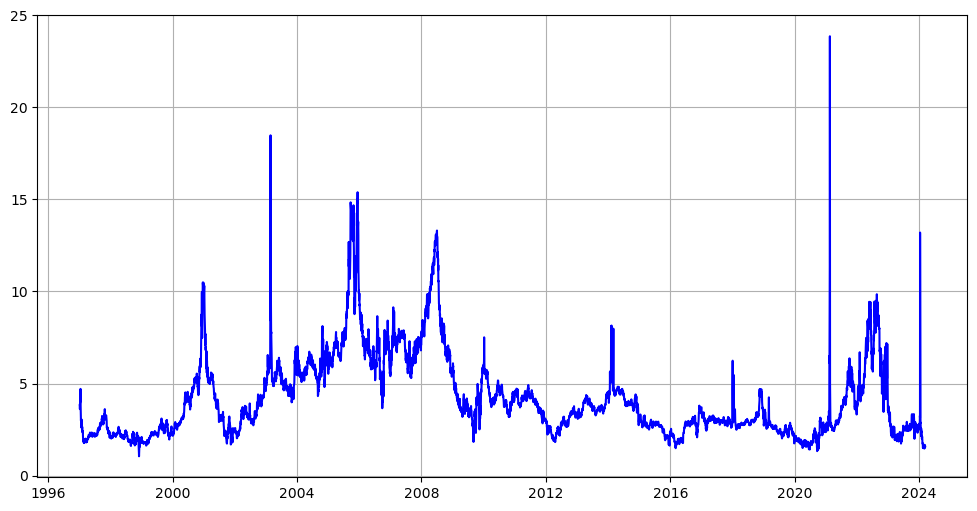

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(df['Price'], color='b')
plt.grid(True)
plt.show()

In [31]:
start_date = '2004-01-01'
end_date = '2024-02-01'

df = df[(df.index >= start_date) & (df.index <= end_date)]
df.shape

(5057, 1)

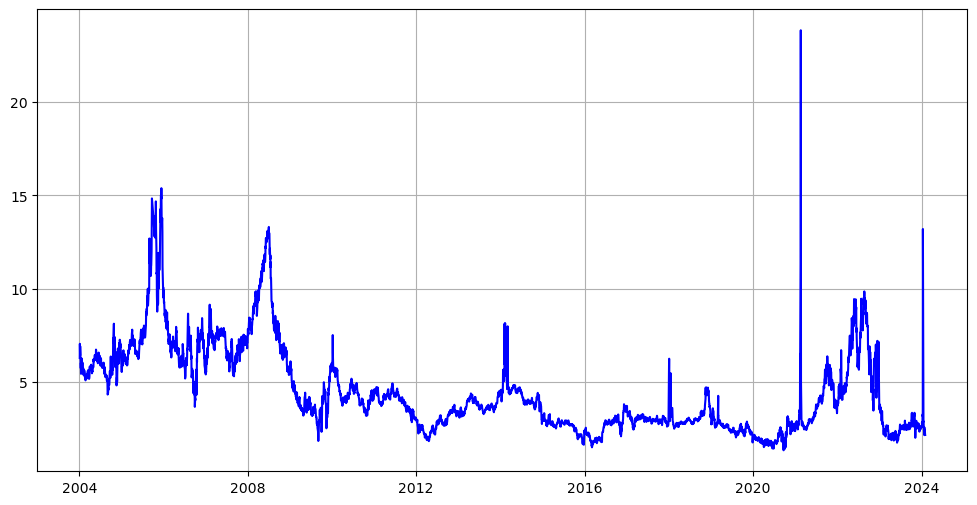

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(df['Price'], color='b')
plt.grid(True)
plt.show()

In [33]:
df=df.reset_index().resample('M', on='Date').mean()
df.shape

(242, 1)

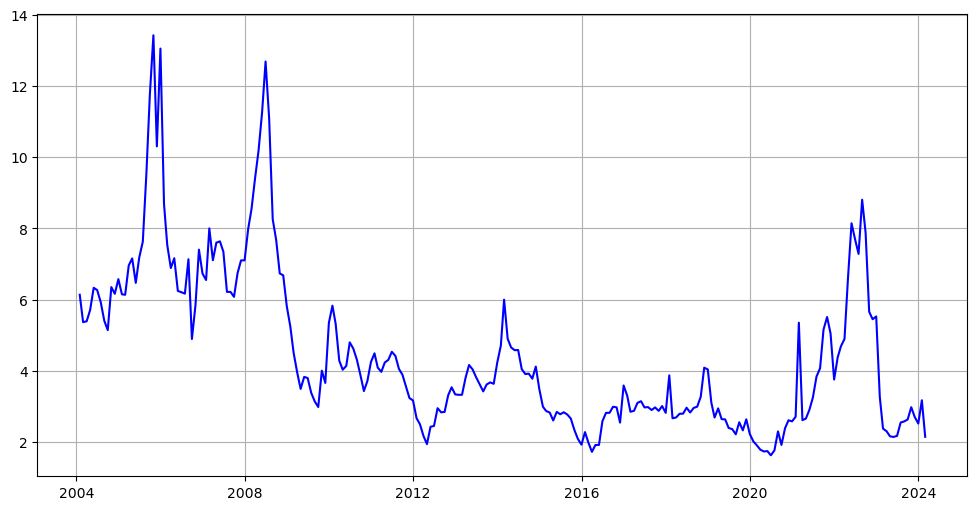

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(df['Price'], color='b')
plt.grid(True)
plt.show()

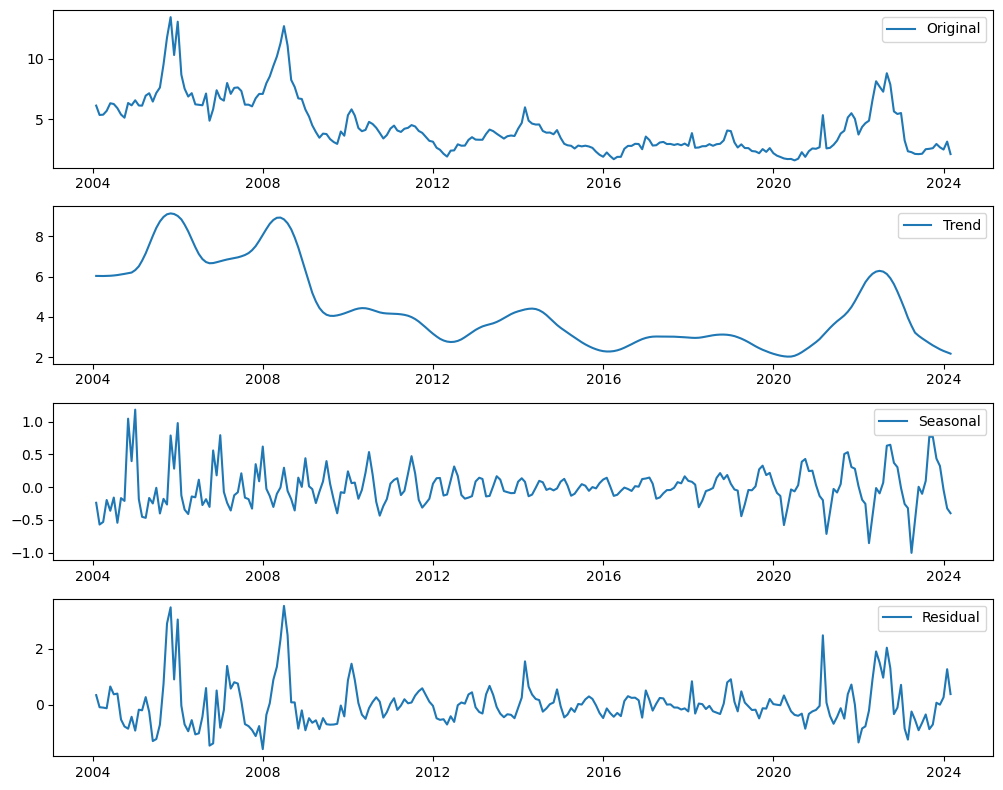

In [37]:
stl_result = STL(df['Price'], seasonal=13).fit()

# Plot the decomposition components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))

ax1.plot(df['Price'], label='Original')
ax1.legend()

ax2.plot(stl_result.trend, label='Trend')
ax2.legend()

ax3.plot(stl_result.seasonal, label='Seasonal')
ax3.legend()

ax4.plot(stl_result.resid, label='Residual')
ax4.legend()

plt.tight_layout()
plt.show()

# SARIMA

In [38]:
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller


In [39]:
adfuller(df['Price'])[:2]

(-2.5528463255579084, 0.10313976014646303)

In [40]:
adfuller(np.diff(df['Price'], n=12))[:2]

(-17.335368631221225, 5.379316196118428e-30)

In [61]:
from itertools import product

ps, qs, Ps, Qs=range(5), range(5), range(5), range(5)
d, D, s=1, 0, 12

arima_orders=list(product(ps, qs, Ps, Qs))

In [62]:
import pandas as pd
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX


def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d:int, D:int, s:int)->pd.DataFrame:
    res=[]
    
    for order in tqdm_notebook(order_list):
        try:
            model=SARIMAX(endog, order=(order[0], d, order[1]), 
                          seasonal_order=(order[2], D, order[3], s),
                          simple_differencing=False).fit(disp=False)
        except:
            continue
        
        aic=model.aic
        res.append([order, aic])
        
    res_df=pd.DataFrame(res)
    res_df.columns=['(p,q,P,Q)', 'AIC']
    res_df=res_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return res_df

In [63]:
train, test=df['Price'][:-3], df['Price'][-3:]
train.shape, test.shape

((239,), (3,))